In [10]:
import uproot
import encode2
import pandas as pd

In [11]:
def getstring(inp):
    st = ""
    for i in inp :
        st += str(i)
    return st

def getencodedlink(nhgc,nln):
    outputencodedwafer = []
    for i in range(0,nhgc):
#        print ("nHGC:",i)
        for j in range(0,nln):
#            print ("nlink:",j)
#            print (getstring(grouped.get_group((i,j ))['encodedCharge']))
            outputencodedwafer.append(getstring(grouped.get_group((i,j ))['encodedCharge']))
    return outputencodedwafer

In [12]:
fName='root://cmseos.fnal.gov//store/user/dnoonan/HGCAL_Concentrator/NewNtuples/ntuple_hgcalNtuples_vbf_hmm_200PU_1.root'
_tree = uproot.open(fName,xrootdsource=dict(chunkbytes=1024**3, limitbytes=1024**3))['hgcalTriggerNtuplizer/HGCalTriggerNtuple']

In [13]:
df = _tree.pandas.df( ['tc_subdet','tc_zside','tc_layer','tc_wafer','tc_cell','tc_data','tc_uncompressedCharge','tc_compressedCharge'],entrystart=0,entrystop=10)
df.columns = ['subdet','zside','layer','wafer','triggercell','data','uncompressedCharge','compressedCharge']

df.set_index(['subdet','zside','layer','wafer','triggercell'],append=True,inplace=True)
df.reset_index('subentry',drop=True,inplace=True)
df.sort_index(inplace=True)
#df['encodedCharge'] = df.uncompressedCharge.apply(encode.encode,args=(True,1,4,3,True))
df['encodedCharge'] = df.uncompressedCharge.apply(encode2.encode,args=(1,4,3,True))
df['decodedCharge'] = df.encodedCharge.apply(encode2.decode,args=(1,4,3))

dftest = df.copy()
dftest.reset_index(inplace=True)
nevents = len(dftest['entry'].unique())
print ("total events:",len(dftest['entry'].unique()))

total events: 10


In [14]:
geomName = "root://cmseos.fnal.gov//store/user/dnoonan/HGCAL_Concentrator/triggerGeomV9.root"
geomTree = uproot.open(geomName,xrootdsource=dict(chunkbytes=1024**3, limitbytes=1024**3))["hgcaltriggergeomtester/TreeTriggerCells"]
geomDF = geomTree.pandas.df(['subdet','zside','layer','wafer','triggercell','c_n'])
geomDF.set_index(['subdet','zside','layer','wafer','triggercell'],inplace=True)
geomDF['isHDM'] = geomDF.c_n>4
geomDF.sort_index(inplace=True)
mapd = pd.read_csv('TC_MAP.csv')

In [20]:
enclist = []
declist = []
uncomplist = []
residuals=[]
wafnumb = 99

In [21]:
for nev in range (0,nevents):
#### Get single wafer (event 0, subdet 3, zside 1, layer 5, wafer 99)
    dfWafer = df.loc[nev,3,1,5,wafnumb]
    geomDFWafer = geomDF.loc[3,1,5,99]
    geomDFWafer['encodedCharge'] = dfWafer['encodedCharge']
    geomDFWafer['decodedCharge'] = dfWafer['decodedCharge']
    geomDFWafer['uncompressedCharge'] = dfWafer['uncompressedCharge']
    geomDFWafer.fillna('0000000',inplace=True)
    geomDFWafer.reset_index(inplace=True)
#    geomDFWafer
    merged = pd.merge(geomDFWafer, mapd, on=['triggercell','isHDM'])
    nhgc = len(merged['nHGROC'].unique())
    nln = len(merged['nlink'].unique())
    #merged.set_index(['nlink'],append=True,inplace=True)
    #merged
    grouped = merged.groupby(['nHGROC','nlink'])
    getencodedlink(nhgc,nln)
    enclist.append(getencodedlink(nhgc,nln))
    decodedlist = merged['decodedCharge'].tolist()
    declist.append(decodedlist)
    uncompressedlist = merged['uncompressedCharge'].tolist()
    uncomplist.append(uncompressedlist)
    print (len(decodedlist))
    for i in range(0,len(decodedlist)):
#        print (uncompressedlist[i],decodedlist[i])
#        residuals.append(abs(int(uncompressedlist[i]) - int(decodedlist[i])))
#        print ((int(uncompressedlist[i]) - int(decodedlist[i])))
        residuals.append((int(uncompressedlist[i]) - int(decodedlist[i])))

/cvmfs/sft.cern.ch/lcg/views/LCG_95apython3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/cvmfs/sft.cern.ch/lcg/views/LCG_95apython3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/cvmfs/sft.cern.ch/lcg/views/LCG_95apython3/x86_64-centos7-gcc8-opt/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

48
48
48
48
48
48
48
48
48
48


480


Text(0.5,0,'residual value')

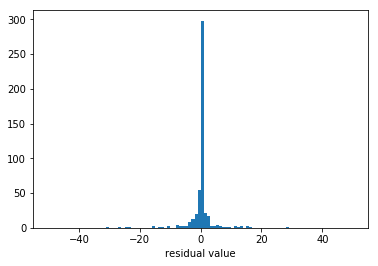

In [22]:
print (len(residuals))
import matplotlib.pyplot as plt
import numpy as np
# if using a Jupyter notebook, includue:
%matplotlib inline
plt.hist(residuals, bins=100,range=(-50,50))
plt.xlabel('residual value')